# Thin film optimization
> Let's optimize a thin film...

> This notebook was contributed by [simbilod](https://github.com/simbilod).

In [1]:
import jax
import jax.example_libraries.optimizers as opt
import jax.numpy as jnp
import matplotlib.pyplot as plt
import sax  # sax circuit simulator
import tqdm.notebook as tqdm
from tmm import coh_tmm

In this notebook, we apply SAX to thin-film optimization and show how it can be used for wavelength-dependent parameter optimization.

The language of transfer/scatter matrices is commonly used to calculate optical properties of thin-films. Many specialized methods exist for their optimization. However, SAX can be useful to cut down on developer time by circumventing the need to manually take gradients of complicated or often-changed objective functions, and by generating efficient code from simple syntax. 

## Dielectric mirror Fabry-Pérot

Consider a stack composed of only two materials, $n_A$ and $n_B$. Two types of transfer matrices characterize wave propagation in the system : interfaces described by Fresnel's equations, and propagation.

For the two-material stack, this leads to 4 scatter matrices coefficients. Through reciprocity they can be constructed out of two independent ones :

In [2]:
def fresnel_mirror_ij(ni=1.0, nj=1.0):
    """Model a (fresnel) interface between twoo refractive indices

    Args:
        ni: refractive index of the initial medium
        nf: refractive index of the final
    """
    r_fresnel_ij = (ni - nj) / (ni + nj)  # i->j reflection
    t_fresnel_ij = 2 * ni / (ni + nj)  # i->j transmission
    r_fresnel_ji = -r_fresnel_ij  # j -> i reflection
    t_fresnel_ji = (1 - r_fresnel_ij ** 2) / t_fresnel_ij  # j -> i transmission
    sdict = {
        ("in", "in"): r_fresnel_ij,
        ("in", "out"): t_fresnel_ij,
        ("out", "in"): t_fresnel_ji,
        ("out", "out"): r_fresnel_ji,
    }
    return sdict


def propagation_i(ni=1.0, di=0.5, wl=0.532):
    """Model the phase shift acquired as a wave propagates through medium A

    Args:
        ni: refractive index of medium (at wavelength wl)
        di: [μm] thickness of layer
        wl: [μm] wavelength
    """
    prop_i = jnp.exp(1j * 2 * jnp.pi * ni * di / wl)
    sdict = {
        ("in", "out"): prop_i,
        ("out", "in"): prop_i,
    }
    return sdict

A resonant cavity can be formed when a high index region is surrounded by low-index region :

In [3]:
dielectric_fabry_perot, _ = sax.circuit(
    netlist={
        "instances": {
            "air_B": fresnel_mirror_ij,
            "B": propagation_i,
            "B_air": fresnel_mirror_ij,
        },
        "connections": {
            "air_B,out": "B,in",
            "B,out": "B_air,in",
        },
        "ports": {
            "in": "air_B,in",
            "out": "B_air,out",
        },
    },
)

settings = sax.get_settings(dielectric_fabry_perot)
settings

{'air_B': {'ni': 1.0, 'nj': 1.0},
 'B': {'ni': 1.0, 'di': 0.5, 'wl': 0.532},
 'B_air': {'ni': 1.0, 'nj': 1.0}}

Let's choose $n_A = 1$, $n_B = 2$, $d_B = 1000$ nm, and compute over the visible spectrum :

In [4]:
settings = sax.copy_settings(settings)
settings["air_B"]["nj"] = 2.0
settings["B"]["ni"] = 2.0
settings["B_air"]["ni"] = 2.0

wls = jnp.linspace(0.380, 0.750, 200)
settings = sax.update_settings(settings, wl=wls)

Compute transmission and reflection, and compare to another package's results (https://github.com/sbyrnes321/tmm) :

In [5]:
%%time
sdict = dielectric_fabry_perot(**settings)

transmitted = sdict["in", "out"]
reflected = sdict["in", "in"]

CPU times: user 786 ms, sys: 7.81 ms, total: 794 ms
Wall time: 792 ms


In [6]:
%%time

# tmm syntax (https://github.com/sbyrnes321/tmm)
d_list = [jnp.inf, 0.500, jnp.inf]
n_list = [1, 2, 1]
# initialize lists of y-values to plot
rnorm = []
tnorm = []
Tnorm = []
Rnorm = []
for l in wls:
    rnorm.append(coh_tmm("s", n_list, d_list, 0, l)["r"])
    tnorm.append(coh_tmm("s", n_list, d_list, 0, l)["t"])
    Tnorm.append(coh_tmm("s", n_list, d_list, 0, l)["T"])
    Rnorm.append(coh_tmm("s", n_list, d_list, 0, l)["R"])

CPU times: user 2.43 s, sys: 11.3 ms, total: 2.44 s
Wall time: 2.44 s


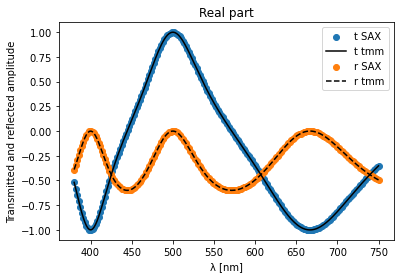

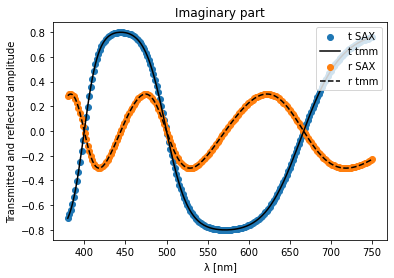

In [7]:
plt.scatter(wls * 1e3, jnp.real(transmitted), label="t SAX")
plt.plot(wls * 1e3, jnp.real(jnp.array(tnorm)), "k", label="t tmm")
plt.scatter(wls * 1e3, jnp.real(reflected), label="r SAX")
plt.plot(wls * 1e3, jnp.real(jnp.array(rnorm)), "k--", label="r tmm")
plt.xlabel("λ [nm]")
plt.ylabel("Transmitted and reflected amplitude")
plt.legend(loc="upper right")
plt.title("Real part")
plt.show()

plt.scatter(wls * 1e3, jnp.imag(transmitted), label="t SAX")
plt.plot(wls * 1e3, jnp.imag(jnp.array(tnorm)), "k", label="t tmm")
plt.scatter(wls * 1e3, jnp.imag(reflected), label="r SAX")
plt.plot(wls * 1e3, jnp.imag(jnp.array(rnorm)), "k--", label="r tmm")
plt.xlabel("λ [nm]")
plt.ylabel("Transmitted and reflected amplitude")
plt.legend(loc="upper right")
plt.title("Imaginary part")
plt.show()

In terms of powers, we get the following. Due to the reflections at the interfaces, resonant behaviour is observed, with evenly-spaced maxima/minima in wavevector space :

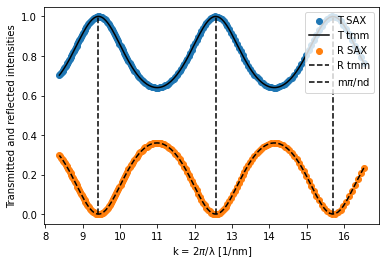

In [8]:
plt.scatter(2 * jnp.pi / wls, jnp.abs(transmitted) ** 2, label="T SAX")
plt.plot(2 * jnp.pi / wls, Tnorm, "k", label="T tmm")
plt.scatter(2 * jnp.pi / wls, jnp.abs(reflected) ** 2, label="R SAX")
plt.plot(2 * jnp.pi / wls, Rnorm, "k--", label="R tmm")
plt.vlines(jnp.arange(3, 6) * jnp.pi / (2 * 0.5), ymin=0, ymax=1, color="k", linestyle="--", label="m$\pi$/nd")
plt.xlabel("k = 2$\pi$/λ [1/nm]")
plt.ylabel("Transmitted and reflected intensities")
plt.legend(loc="upper right")
plt.show()

### Optimization test

Let's attempt to minimize transmission at 500 nm by varying thickness.

In [9]:
@jax.jit
def loss(thickness):
    settings = sax.update_settings(sax.get_settings(dielectric_fabry_perot), wl=0.5)
    settings["B"]["di"] = thickness
    settings["air_B"]["nj"] = 2.0
    settings["B"]["ni"] = 2.0
    settings["B_air"]["ni"] = 2.0
    sdict = dielectric_fabry_perot(**settings)
    return jnp.abs(sdict["in", "out"]) ** 2

In [10]:
grad = jax.jit(jax.grad(loss))

In [11]:
initial_thickness = 0.5
optim_init, optim_update, optim_params = opt.adam(step_size=0.01)
optim_state = optim_init(initial_thickness)


def train_step(step, optim_state):
    thickness = optim_params(optim_state)
    lossvalue = loss(thickness)
    gradvalue = grad(thickness)
    optim_state = optim_update(step, gradvalue, optim_state)
    return lossvalue, optim_state

In [12]:
range_ = tqdm.trange(100)
for step in range_:
    lossvalue, optim_state = train_step(step, optim_state)
    range_.set_postfix(loss=f"{lossvalue:.6f}")

  0%|          | 0/100 [00:00<?, ?it/s]

In [13]:
thickness = optim_params(optim_state)
thickness

0.56254

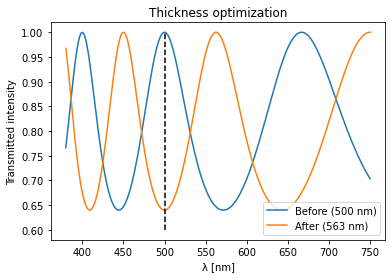

In [14]:
settings = sax.update_settings(sax.get_settings(dielectric_fabry_perot), wl=wls)
settings["B"]["di"] = thickness
settings["air_B"]["nj"] = 2.0
settings["B"]["ni"] = 2.0
settings["B_air"]["ni"] = 2.0
sdict = dielectric_fabry_perot(**settings)
detected = sdict["in", "out"]

plt.plot(wls * 1e3, jnp.abs(transmitted) ** 2, label="Before (500 nm)")
plt.plot(wls * 1e3, jnp.abs(detected) ** 2, label=f"After ({thickness*1e3:.0f} nm)")
plt.vlines(0.5 * 1e3, 0.6, 1, "k", linestyle="--")
plt.xlabel("λ [nm]")
plt.ylabel("Transmitted intensity")
plt.legend(loc="lower right")
plt.title("Thickness optimization")
plt.show()

## General Fabry-Pérot étalon

We reuse the propagation matrix above, and instead of simple interface matrices, model Fabry-Pérot mirrors as general lossless reciprocal scatter matrices :

$$ \left(\begin{array}{c} 
E_t \\
E_r
\end{array}\right) = E_{out} = SE_{in} = \left(\begin{array}{cc} 
t & r \\
r & t
\end{array}\right) \left(\begin{array}{c} 
E_0 \\
0
\end{array}\right) $$

For lossless reciprocal systems, we further have the requirements

$$ |t|^2 + |r|^2 = 1 $$

and

$$ \angle t - \angle r = \pm \pi/2 $$

The general Fabry-Pérot cavity is analytically described by :

In [15]:
def airy_t13(t12, t23, r21, r23, wl, d=1.0, n=1.0):
    """General Fabry-Pérot transmission transfer function (Airy formula)

    Args:
        t12 and r12 : S-parameters of the first mirror
        t23 and r23 : S-parameters of the second mirror
        wl : wavelength
        d : gap between the two mirrors (in units of wavelength)
        n : index of the gap between the two mirrors

    Returns:
        t13 : complex transmission amplitude of the mirror-gap-mirror system

    Note:
        Each mirror is assumed to be lossless and reciprocal : tij = tji, rij = rji
    """
    phi = n * 2 * jnp.pi * d / wl
    return t12 * t23 * jnp.exp(-1j * phi) / (1 - r21 * r23 * jnp.exp(-2j * phi))


def airy_r13(t12, t23, r21, r23, wl, d=1.0, n=1.0):
    """General Fabry-Pérot reflection transfer function (Airy formula)

    Args:
        t12 and r12 : S-parameters of the first mirror
        t23 and r23 : S-parameters of the second mirror
        wl : wavelength
        d : gap between the two mirrors (in units of wavelength)
        n : index of the gap between the two mirrors

    Returns:
        r13 : complex reflection amplitude of the mirror-gap-mirror system

    Note:
        Each mirror is assumed to be lossless and reciprocal : tij = tji, rij = rji
    """
    phi = n * 2 * jnp.pi * d / wl
    return r21 + t12 * t12 * r23 * jnp.exp(-2j * phi) / (1 - r21 * r23 * jnp.exp(-2j * phi))

We need to implement the relationship between $t$ and $r$ for lossless reciprocal mirrors. The design parameter will be the amplitude and phase of the tranmission coefficient. The reflection coefficient is then fully determined :

In [16]:
def t_complex(t_amp, t_ang):
    return t_amp * jnp.exp(-1j * t_ang)


def r_complex(t_amp, t_ang):
    r_amp = jnp.sqrt((1.0 - t_amp ** 2))
    r_ang = t_ang - jnp.pi / 2
    return r_amp * jnp.exp(-1j * r_ang)

Let's see the expected result for half-mirrors :

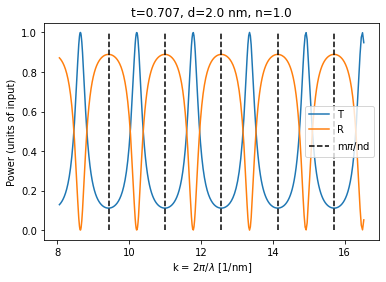

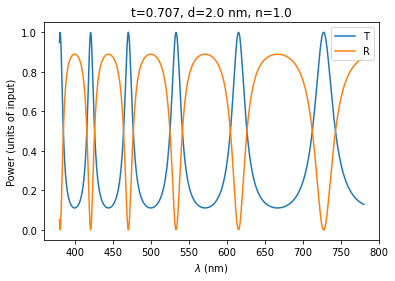

In [17]:
t_initial = jnp.sqrt(0.5)
d_gap = 2.0
n_gap = 1.0
r_initial = r_complex(t_initial, 0.0)

wls = jnp.linspace(0.38, 0.78, 500)

T_analytical_initial = jnp.abs(airy_t13(t_initial, t_initial, r_initial, r_initial, wls, d=d_gap, n=n_gap)) ** 2
R_analytical_initial = jnp.abs(airy_r13(t_initial, t_initial, r_initial, r_initial, wls, d=d_gap, n=n_gap)) ** 2 

plt.title(f"t={t_initial:1.3f}, d={d_gap} nm, n={n_gap}")
plt.plot(2 * jnp.pi / wls, T_analytical_initial, label="T")
plt.plot(2 * jnp.pi / wls, R_analytical_initial, label="R")
plt.vlines(jnp.arange(6, 11) * jnp.pi / 2.0, ymin=0, ymax=1, color="k", linestyle="--", label="m$\pi$/nd")
plt.xlabel("k = 2$\pi$/$\lambda$ [1/nm]")
plt.ylabel("Power (units of input)")
plt.legend()
plt.show()

plt.title(f"t={t_initial:1.3f}, d={d_gap} nm, n={n_gap}")
plt.plot(wls * 1e3, T_analytical_initial, label="T")
plt.plot(wls * 1e3, R_analytical_initial, label="R")
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("Power (units of input)")
plt.legend()
plt.show()

In [18]:
# Is power conserved? (to within 0.1%)
assert jnp.isclose(R_analytical_initial + T_analytical_initial, 1, 0.001).all()

Now let's do the same with SAX by defining new elements :

In [19]:
def mirror(t_amp=0.5**0.5, t_ang=0.0):
    r_complex_val = r_complex(t_amp, t_ang)
    t_complex_val = t_complex(t_amp, t_ang)
    sdict = {
        ("in", "in"): r_complex_val,
        ("in", "out"): t_complex_val,
        ("out", "in"): t_complex_val,  # (1 - r_complex_val**2)/t_complex_val, # t_ji
        ("out", "out"): r_complex_val,  # -r_complex_val, # r_ji
    }
    return sdict


fabry_perot_tunable, _ = sax.circuit(
    netlist={
        "instances": {
            "mirror1": mirror,
            "gap": propagation_i,
            "mirror2": mirror,
        },
        "connections": {
            "mirror1,out": "gap,in",
            "gap,out": "mirror2,in",
        },
        "ports": {
            "in": "mirror1,in",
            "out": "mirror2,out",
        },
    }
)

settings = sax.get_settings(fabry_perot_tunable)
settings

{'mirror1': {'t_amp': 0.70711, 't_ang': 0.0},
 'gap': {'ni': 1.0, 'di': 0.5, 'wl': 0.532},
 'mirror2': {'t_amp': 0.70711, 't_ang': 0.0}}

In [20]:
fabry_perot_tunable, _ = sax.circuit(
    netlist={
        "instances": {
            "mirror1": mirror,
            "gap": propagation_i,
            "mirror2": mirror,
        },
        "connections": {
            "mirror1,out": "gap,in",
            "gap,out": "mirror2,in",
        },
        "ports": {
            "in": "mirror1,in",
            "out": "mirror2,out",
        },
    },
)

settings = sax.get_settings(fabry_perot_tunable)
settings

{'mirror1': {'t_amp': 0.70711, 't_ang': 0.0},
 'gap': {'ni': 1.0, 'di': 0.5, 'wl': 0.532},
 'mirror2': {'t_amp': 0.70711, 't_ang': 0.0}}

In [21]:
N = 100
wls = jnp.linspace(0.38, 0.78, N)
settings = sax.get_settings(fabry_perot_tunable)
settings = sax.update_settings(settings, wl=wls, t_amp=jnp.sqrt(0.5), t_ang=0.0)
settings["gap"]["ni"] = 1.0
settings["gap"]["di"] = 2.0
transmitted_initial = fabry_perot_tunable(**settings)["in", "out"]
reflected_initial = fabry_perot_tunable(**settings)["out", "out"]

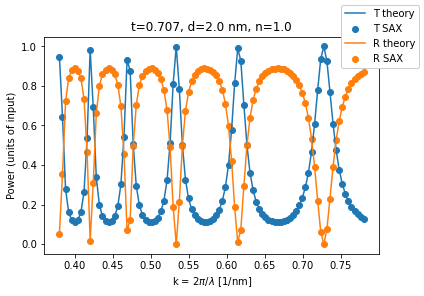

In [22]:
T_analytical_initial = jnp.abs(airy_t13(t_initial, t_initial, r_initial, r_initial, wls, d=d_gap, n=n_gap))**2
R_analytical_initial = jnp.abs(airy_r13(t_initial, t_initial, r_initial, r_initial, wls, d=d_gap, n=n_gap))**2
plt.title(f"t={t_initial:1.3f}, d={d_gap} nm, n={n_gap}")
plt.plot(wls, T_analytical_initial, label="T theory")
plt.scatter(wls, jnp.abs(transmitted_initial) ** 2, label="T SAX")
plt.plot(wls, R_analytical_initial, label="R theory")
plt.scatter(wls, jnp.abs(reflected_initial) ** 2, label="R SAX")
plt.xlabel("k = 2$\pi$/$\lambda$ [1/nm]")
plt.ylabel("Power (units of input)")
plt.figlegend(framealpha=1.0)
plt.show()

## Wavelength-dependent Fabry-Pérot étalon

Let's repeat with a model where parameters can be wavelength-dependent. To comply with the optimizer object, we will stack all design parameters in a single array :

In [23]:
ts_initial = jnp.zeros(2 * N)
ts_initial = ts_initial.at[0:N].set(jnp.sqrt(0.5))

We will simply loop over all wavelengths, and use different $t$ parameters at each wavelength.

In [24]:
wls = jnp.linspace(0.38, 0.78, N)
transmitted = jnp.zeros_like(wls)
reflected = jnp.zeros_like(wls)
settings = sax.get_settings(fabry_perot_tunable)
settings = sax.update_settings(settings, wl=wls, t_amp=ts_initial[:N], t_ang=ts_initial[N:])
settings["gap"]["ni"] = 1.0
settings["gap"]["di"] = 2.0
# Perform computation
sdict = fabry_perot_tunable(**settings)
transmitted = jnp.abs(sdict["in", "out"]) ** 2
reflected = jnp.abs(sdict["in", "in"]) ** 2

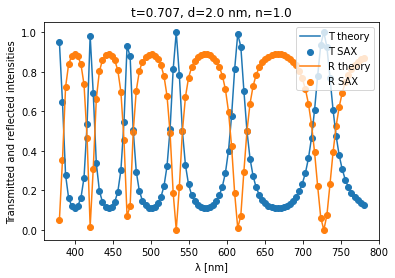

In [25]:
plt.plot(wls * 1e3, T_analytical_initial, label="T theory")
plt.scatter(wls * 1e3, transmitted, label="T SAX")
plt.plot(wls * 1e3, R_analytical_initial, label="R theory")
plt.scatter(wls * 1e3, reflected, label="R SAX")
plt.xlabel("λ [nm]")
plt.ylabel("Transmitted and reflected intensities")
plt.legend(loc="upper right")
plt.title(f"t={t_initial:1.3f}, d={d_gap} nm, n={n_gap}")
plt.show()

Since it seems to work, let's add a target and optimize some harmonics away :

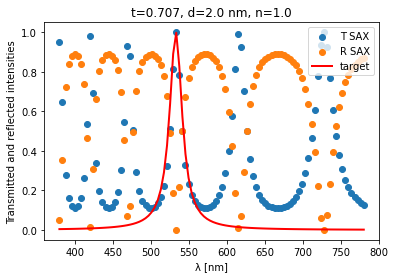

In [26]:
def lorentzian(l0, dl, wl, A):
    return A / ((wl - l0) ** 2 + (0.5 * dl) ** 2)


target = lorentzian(533.0, 20.0, wls * 1e3, 100.0)

plt.scatter(wls * 1e3, transmitted, label="T SAX")
plt.scatter(wls * 1e3, reflected, label="R SAX")
plt.plot(wls * 1e3, target, "r", linewidth=2, label="target")
plt.xlabel("λ [nm]")
plt.ylabel("Transmitted and reflected intensities")
plt.legend(loc="upper right")
plt.title(f"t={t_initial:1.3f}, d={d_gap} nm, n={n_gap}")
plt.show()

In [27]:
@jax.jit
def loss(ts):
    N = len(ts[::2])
    wls = jnp.linspace(0.38, 0.78, N)
    target = lorentzian(533.0, 20.0, wls * 1e3, 100.0)
    settings = sax.get_settings(fabry_perot_tunable)
    settings = sax.update_settings(settings, wl=wls, t_amp=ts[:N], t_ang=ts[N:])
    settings["gap"]["ni"] = 1.0
    settings["gap"]["di"] = 2.0
    sdict = fabry_perot_tunable(**settings)
    transmitted = jnp.abs(sdict["in", "out"]) ** 2
    return (jnp.abs(transmitted - target) ** 2).mean()

In [28]:
grad = jax.jit(jax.grad(loss))

In [29]:
optim_init, optim_update, optim_params = opt.adam(step_size=0.001)

def train_step(step, optim_state):
    ts = optim_params(optim_state)
    lossvalue = loss(ts)
    gradvalue = grad(ts)
    optim_state = optim_update(step, gradvalue, optim_state)
    return lossvalue, gradvalue, optim_state

In [30]:
range_ = tqdm.trange(2000)

optim_state = optim_init(ts_initial)
for step in range_:
    lossvalue, gradvalue, optim_state = train_step(step, optim_state)
    range_.set_postfix(loss=f"{lossvalue:.6f}")

  0%|          | 0/2000 [00:00<?, ?it/s]

The optimized parameters are now wavelength-dependent :

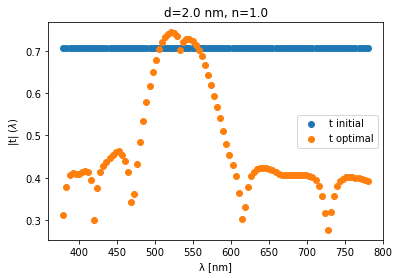

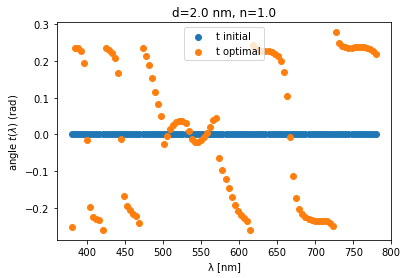

In [31]:
ts_optimal = optim_params(optim_state)

plt.scatter(wls * 1e3, ts_initial[:N], label="t initial")
plt.scatter(wls * 1e3, ts_optimal[:N], label="t optimal")
plt.xlabel("λ [nm]")
plt.ylabel("|t| $(\lambda)$")
plt.legend(loc="best")
plt.title(f"d={d_gap} nm, n={n_gap}")
plt.show()

plt.scatter(wls * 1e3, ts_initial[N:], label="t initial")
plt.scatter(wls * 1e3, ts_optimal[N:], label="t optimal")
plt.xlabel("λ [nm]")
plt.ylabel("angle $t (\lambda)$ (rad)")
plt.legend(loc="best")
plt.title(f"d={d_gap} nm, n={n_gap}")
plt.show()

Visualizing the result :

In [32]:
wls = jnp.linspace(0.38, 0.78, N)
transmitted_optimal = jnp.zeros_like(wls)
reflected_optimal = jnp.zeros_like(wls)

settings = sax.get_settings(fabry_perot_tunable)
settings = sax.update_settings(
    settings, wl=wls, t_amp=ts_optimal[:N], t_ang=ts_optimal[N:]
)
settings["gap"]["ni"] = 1.0
settings["gap"]["di"] = 2.0
transmitted_optimal = jnp.abs(fabry_perot_tunable(**settings)["in", "out"]) ** 2
reflected_optimal = jnp.abs(fabry_perot_tunable(**settings)["in", "in"]) ** 2

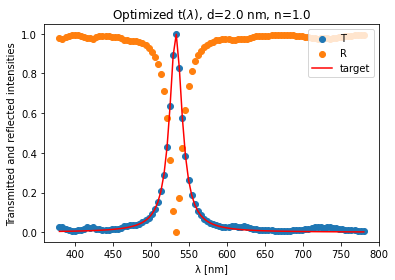

In [33]:
plt.scatter(wls * 1e3, transmitted_optimal, label="T")
plt.scatter(wls * 1e3, reflected_optimal, label="R")
plt.plot(wls * 1e3, lorentzian(533, 20, wls * 1e3, 100), "r", label="target")
plt.xlabel("λ [nm]")
plt.ylabel("Transmitted and reflected intensities")
plt.legend(loc="upper right")
plt.title(f"Optimized t($\lambda$), d={d_gap} nm, n={n_gap}")
plt.show()

The hard part is now to find physical stacks that physically implement $t(\lambda)$. However, the ease with which we can modify and complexify the loss function opens opportunities for regularization and more complicated objective functions.

The models above are available in `sax.models.thinfilm`, and can straightforwardly be extended to propagation at an angle, s and p polarizations, nonreciprocal systems, and systems with losses.